### <b>Table of Content</b>

0. Import functions

1. Load data

2. 

2. Create Bollinger Bands

### <b>0. Import functions</b>

In [33]:
import sys
import os
from pathlib import Path

from utils.load import load_dataframes
from utils.transform import convert_vol_to_float, add_moving_average, add_seasonal_components, add_datetime_features,\
                            normalize_scale
from utils.plot import plot_histograms
from utils.stats_functions import run_chi_tests

import warnings
warnings.simplefilter("ignore", UserWarning)

### <b>1. Load data</b>

In [34]:
# Details of the source file in G Drive
base_url = "https://drive.google.com/file/d/"
file_id = "1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk"
file_url = f"{base_url}{file_id}"
file_name = "2020Q1Q2Q3Q4-2021Q1.xlsx"

# Manually define sheet names as xlsx files have a 31-character limitation on sheet names.
full_sheet_names = [
    "Russia - Sberbank Rossii PAO (SBER)",
    "Turkey - Koc Holding AS (KCHOL)",
    "Egypt - Medinet Nasr Housing (MNHD)",
    "Brazil - Minerva SA/Brazil (BEEF3)",
    "Argentina - Pampa Energia SA (PAMP)",
    "Colombia - Cementos Argos SA (CCB)",
    "South Africa - Impala Platinum Holdings Ltd (IMPJ)",
    "South Korea - Dongkuk Steel Mill Co Ltd (001230)"
]

# Details of local directories
root_dir = sys.path[0]
download_dir = Path(root_dir) / "data"
file_path = download_dir / file_name

if os.path.exists(file_path):
    print(f"File {file_name} already exists in {download_dir}.")
else:
    if os.getcwd() != download_dir:
        os.chdir(download_dir)
    print(f"File {file_name} is not found in {download_dir}.")
    !gdown 1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk

if os.getcwd() != root_dir:
    os.chdir(root_dir)

File 2020Q1Q2Q3Q4-2021Q1.xlsx already exists in d:\OneDrive\GitHub\Apziva\FAxAtx2ZjFTGstEu\data.


### <b>2. Perform basic EDA</b>

In [35]:
data_dfs = load_dataframes(file_path, full_sheet_names)
print(f"{len(data_dfs)} DataFrames loaded with the following sheet names:\n")
for sheet_name in full_sheet_names:
    print(sheet_name)

print("\n\nBasic info of the first DateFrame:\n")
print(data_dfs[full_sheet_names[0]].info())

print("\n\nTail of the first DataFrame:")
data_dfs[full_sheet_names[0]].tail()

8 DataFrames loaded with the following sheet names:

Russia - Sberbank Rossii PAO (SBER)
Turkey - Koc Holding AS (KCHOL)
Egypt - Medinet Nasr Housing (MNHD)
Brazil - Minerva SA/Brazil (BEEF3)
Argentina - Pampa Energia SA (PAMP)
Colombia - Cementos Argos SA (CCB)
South Africa - Impala Platinum Holdings Ltd (IMPJ)
South Korea - Dongkuk Steel Mill Co Ltd (001230)


Basic info of the first DateFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      311 non-null    datetime64[ns]
 1   Price     311 non-null    float64       
 2   Open      311 non-null    float64       
 3   High      311 non-null    float64       
 4   Low       311 non-null    float64       
 5   Vol.      311 non-null    object        
 6   Change %  311 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 17.1+ KB
None


Ta

,Date,Price,Open,High,Low,Vol.,Change %
306,2020-01-10,258.19,257.86,259.25,256.88,18.85M,0.0008
307,2020-01-09,257.99,259.40,261.76,257.01,38.33M,-0.0045
308,2020-01-08,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06,253.90,254.75,254.84,251.40,22.35M,-0.0043
310,2020-01-03,255.00,255.99,258.19,253.70,35.85M,0.0010


some description of the data set to be added.

### <b>3. Transform data types and split data into train and test sets</b>

Convert the Vol. column from string (object) to float so that it can be plotted and fed into a machine learning model.

Also, only select data from 2020 as training data and data from 2021 as test data.

In [53]:
import pandas as pd
from datetime import timedelta

def add_data_from_past(df, drop_na=True):
    original_index = df.index
    df = df.asfreq('D').ffill()

    df_prev_day = df.loc[ (df.index - timedelta(days=1))[1:] ].rename(
        columns = {column: column + " (-1 day)" for column in df.columns})
    df_prev_day.index += timedelta(days=1)

    df_prev_week = df.loc[ (df.index - timedelta(days=7))[7:] ].rename(
        columns = {column: column + " (-1 week)" for column in df.columns})
    df_prev_week.index += timedelta(days=7)

    df_prev_month = df.loc[ (df.index - timedelta(days=30))[30:] ].rename(
        columns = {column: column + " (-1 month)" for column in df.columns})
    df_prev_month.index += timedelta(days=30)

    concat_df = pd.concat([df, df_prev_day, df_prev_week, df_prev_month], axis=1)
    # concat_df = pd.concat([df, df_prev_day], axis=1)
    
    concat_df = concat_df.loc[original_index]

    if drop_na:
        concat_df = concat_df.dropna()

    return concat_df

In [55]:
train_dfs = {}
for name, df in data_dfs.items():
    df_copy = df.set_index('Date').sort_index().rename(columns={'Price': 'Close'})
    df_copy['Vol.'] = df_copy['Vol.'].apply(convert_vol_to_float)
    
    df_updated = add_data_from_past(df_copy)
    train_dfs[name] = df_updated
    
#     train_df = df_copy[df_copy['Date'].dt.year == 2020]\
#             .set_index('Date').sort_index()\
#             .rename(columns={'Price': 'Close'})
#     test_df = df_copy[df_copy['Date'].dt.year == 2021]\
#             .set_index('Date').sort_index()\
#             .rename(columns={'Price': 'Close'})
#     train_dfs[name] = (train_df, test_df)

In [56]:
stock_name_1 = full_sheet_names[0]
# train_df_1, test_df_1 = train_dfs[stock_name_1]
df_1 = train_dfs[stock_name_1]
df_1

,Close,Open,High,Low,Vol.,Change %,Close (-1 day),Open (-1 day),High (-1 day),Low (-1 day),...,High (-1 week),Low (-1 week),Vol. (-1 week),Change % (-1 week),Close (-1 month),Open (-1 month),High (-1 month),Low (-1 month),Vol. (-1 month),Change % (-1 month)
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-03,253.99,251.80,254.96,251.10,52730000.0,0.0071,252.20,258.50,259.20,252.17,...,262.10,255.32,56450000.0,-0.0383,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-02-04,255.40,255.30,257.38,252.90,49790000.0,0.0056,253.99,251.80,254.96,251.10,...,258.84,254.10,48140000.0,0.0093,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-02-05,255.20,255.89,257.66,253.14,50760000.0,-0.0008,255.40,255.30,257.38,252.90,...,261.57,257.61,35050000.0,0.0087,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-02-06,252.11,256.50,258.00,251.86,43620000.0,-0.0121,255.20,255.89,257.66,253.14,...,258.69,255.27,31770000.0,-0.0101,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-02-07,254.30,253.10,254.30,248.73,50230000.0,0.0087,252.11,256.50,258.00,251.86,...,259.20,252.17,47920000.0,-0.0199,259.15,253.57,259.15,253.03,40820000.0,0.0207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030,285.79,283.40,288.00,282.25,...,285.79,278.24,74130000.0,-0.0145,273.71,270.10,274.46,268.12,48130000.0,0.0118
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159,286.66,286.50,287.03,283.85,...,286.31,278.03,84250000.0,0.0223,271.90,272.12,272.75,269.42,64190000.0,-0.0066
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071,291.22,288.63,292.75,288.32,...,291.20,283.08,62760000.0,0.0111,270.17,268.00,272.49,266.43,74890000.0,-0.0020


add details from the previous date, week, and month as training features, and predict whether today's "Change %" will be positive or negative.

if predicted to be positive, buy. if predicted to be negative, sell. otherwise hold. add a target column based on the trading decision made based on the predicted change % - buy = 1, hold = 0, and sell = -1. This would be a regression problem?

In [112]:
df_1["Price Move"] = df_1["Change %"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
# Trading decision: 1=Buy, 0=Hold, -1=Sell

train_df_1 = df_1[df_1.index.year == 2020]
X_train_1 = train_df_1.iloc[:, 6:-1]
y_train_1 = train_df_1["Price Move"]

test_df_1 = df_1[df_1.index.year == 2021]
X_test_1 = test_df_1.iloc[:, 6:-1]
y_test_1 = test_df_1["Price Move"]

In [113]:
X_train_1.head()

,Close (-1 day),Open (-1 day),High (-1 day),Low (-1 day),Vol. (-1 day),Change % (-1 day),Close (-1 week),Open (-1 week),High (-1 week),Low (-1 week),Vol. (-1 week),Change % (-1 week),Close (-1 month),Open (-1 month),High (-1 month),Low (-1 month),Vol. (-1 month),Change % (-1 month)
Date,,,,,,,,,,,,,,,,,,
2020-02-03,252.20,258.50,259.20,252.17,47920000.0,-0.0199,255.32,261.0,262.10,255.32,56450000.0,-0.0383,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-02-04,253.99,251.80,254.96,251.10,52730000.0,0.0071,257.70,257.0,258.84,254.10,48140000.0,0.0093,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-02-05,255.40,255.30,257.38,252.90,49790000.0,0.0056,259.94,258.4,261.57,257.61,35050000.0,0.0087,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-02-06,255.20,255.89,257.66,253.14,50760000.0,-0.0008,257.31,258.0,258.69,255.27,31770000.0,-0.0101,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-02-07,252.11,256.50,258.00,251.86,43620000.0,-0.0121,252.20,258.5,259.20,252.17,47920000.0,-0.0199,259.15,253.57,259.15,253.03,40820000.0,0.0207


In [114]:
y_train_1.value_counts()

 1    118
-1    111
 0      1
Name: Price Move, dtype: int64

In [115]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=5)
clf.fit(X_train_1, y_train_1)
clf.score(X_test_1, y_test_1)

0.5245901639344263

In [116]:
preds = clf.predict(X_test_1)
preds

array([-1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1], dtype=int64)

In [176]:
X_test_1[["Close (-1 day)"]]

Date
2021-01-04    271.65
2021-01-05    272.00
2021-01-06    275.20
2021-01-08    272.93
2021-01-11    283.64
               ...  
2021-03-25    285.79
2021-03-26    286.66
2021-03-29    291.22
2021-03-30    293.30
2021-03-31    293.25
Name: Close (-1 day), Length: 61, dtype: float64

In [179]:
results_df = pd.concat([
    df_1.loc[y_test_1.index][["Close", "Open", "High", "Low"]],
    X_test_1[["Close (-1 day)"]]
], axis=1)
results_df['Predicted Price Move'] = preds
results_df

# Predicted Price Move is based on data from previous day, week and month.
# If -1, sell at Open price and buy at Close Price
# if 1, buy at Open price and sell at Close price.

,Close,Open,High,Low,Close (-1 day),Predicted Price Move
Date,,,,,,
2021-01-04,272.00,274.67,276.60,270.61,271.65,-1
2021-01-05,275.20,272.69,275.70,270.28,272.00,1
2021-01-06,272.93,275.94,275.94,271.62,275.20,1
2021-01-08,283.64,275.11,283.99,275.11,272.93,1
2021-01-11,289.49,282.86,292.95,279.48,283.64,-1
...,...,...,...,...,...,...
2021-03-25,286.66,286.50,287.03,283.85,285.79,-1
2021-03-26,291.22,288.63,292.75,288.32,286.66,-1
2021-03-29,293.30,289.72,294.09,289.26,291.22,-1


In [197]:
# If -1, sell at Open price
# if 1, buy at Open price

initial_balance = 1000
initial_no_stock = 20
previous_close_price = X_test_1["Close (-1 day)"].values[0]
intial_investment = initial_no_stock * previous_close_price
print(f"Initial investment: {initial_balance} + ({initial_no_stock} * {previous_close_price}) = {intial_investment}")
max_no_stock_to_trade = 2

first_index = results_df.index[0]
last_index = results_df.index[-1]

for i, row in results_df.iterrows():
    open = row["Open"]
    close = row["Close"]
    pred = row['Predicted Price Move']
    
    if i == first_index:
        previous_balance = initial_balance
        previous_no_stock = initial_no_stock
    else:
        previous_balance = results_df.loc[previous_index, 'Balance']
        previous_no_stock = results_df.loc[previous_index, 'No. of Stock']

    if (pred == 1) and (i != last_index) and (previous_balance >= open):
        # Today's price is predicted to go up. Buy at Open price.
        results_df.loc[i, 'Trade Decision'] = 'Buy'

        max_no_stock_to_buy = previous_balance // open
        no_stock_to_buy = min( max_no_stock_to_trade, max_no_stock_to_buy )

        results_df.loc[i, 'Balance'] = previous_balance - (open * no_stock_to_buy)
        results_df.loc[i, 'No. of Stock'] = previous_no_stock + no_stock_to_buy

    elif pred == -1:
        # Today's price is predicted to go down. Sell at Open price.
        if previous_no_stock > 0:
            results_df.loc[i, 'Trade Decision'] = 'Sell'        
            
            if i == last_index:
                no_stock_to_sell = previous_no_stock
            else:
                no_stock_to_sell = min( max_no_stock_to_trade, previous_no_stock)

            results_df.loc[i, 'Balance'] = previous_balance + (open * no_stock_to_sell)
            results_df.loc[i, 'No. of Stock'] = previous_no_stock - no_stock_to_sell

        # Buy at Close price when no stock to sell at Open price
        # since Close price is predicted to be lower than Open price.
        elif (previous_balance > close) and not (i == last_index):
            results_df.loc[i, 'Trade Decision'] = 'Buy'
            max_no_stock_to_buy = previous_balance // close
            no_stock_to_buy = min( max_no_stock_to_trade, max_no_stock_to_buy )
            results_df.loc[i, 'Balance'] = previous_balance - (close * no_stock_to_buy)
            results_df.loc[i, 'No. of Stock'] = previous_no_stock + no_stock_to_buy

    else:
        results_df.loc[i, 'Trade Decision'] = 'Hold'
        results_df.loc[i, 'Balance'] = previous_balance
        results_df.loc[i, 'No. of Stock'] = previous_no_stock

    previous_index = i

results_df['Capital Return'] = results_df['Balance'] - initial_balance - intial_investment
results_df['Capital Return %'] = round(results_df['Capital Return'] / (intial_investment + initial_balance), 4)
results_df.tail(10)

Initial investment: 1000 + (20 * 271.65) = 5433.0


,Close,Open,High,Low,Close (-1 day),Predicted Price Move,Trade Decision,Balance,No. of Stock,Capital Return,Capital Return %
Date,,,,,,,,,,,
2021-03-18,279.25,284.04,285.79,278.24,283.35,-1,Sell,6964.32,0.0,531.32,0.0826
2021-03-19,285.47,279.00,286.31,278.03,279.25,-1,Buy,6393.38,2.0,-39.62,-0.0062
2021-03-22,288.65,285.00,291.20,283.08,285.47,-1,Sell,6963.38,0.0,530.38,0.0824
2021-03-23,282.60,287.56,288.30,282.11,288.65,-1,Buy,6398.18,2.0,-34.82,-0.0054
2021-03-24,285.79,283.40,288.00,282.25,282.60,1,Buy,5831.38,4.0,-601.62,-0.0935
2021-03-25,286.66,286.50,287.03,283.85,285.79,-1,Sell,6404.38,2.0,-28.62,-0.0044
2021-03-26,291.22,288.63,292.75,288.32,286.66,-1,Sell,6981.64,0.0,548.64,0.0853
2021-03-29,293.30,289.72,294.09,289.26,291.22,-1,Buy,6395.04,2.0,-37.96,-0.0059
2021-03-30,293.25,294.86,295.72,291.50,293.30,-1,Sell,6984.76,0.0,551.76,0.0858


In [198]:
results_df['Trade Decision'].value_counts()

Sell    31
Buy     21
Hold     9
Name: Trade Decision, dtype: int64

In [199]:
results_df['Predicted Price Move'].value_counts()

-1    35
 1    26
Name: Predicted Price Move, dtype: int64

In [111]:
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

random_state = 5
n_splits = 1
n_repeats = 1

le = LabelEncoder()
xgb_clf = XGBClassifier(random_state=random_state)
xgb_clf.fit(X_train_1, le.fit_transform(y_train_1)) 
preds = le.inverse_transform( xgb_clf.predict(X_test_1) )

cm = confusion_matrix(y_test_1, preds)
print(cm)
print(accuracy_score(y_test_1, preds))

# create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_clf)

scores = cross_val_score(xgb_clf,
                         X_train_1,
                         y_train_1.values.reshape(-1, 1),
                         scoring='roc_auc', # roc_auc, accuracy, f1
                        #  cv=RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
                         )
score_stats = {
    "Mean": round(np.mean(scores), 4),
    "Std": round(np.std(scores), 4),
    "Max": round(np.max(scores), 4),
    "75th Percentile": round(np.percentile(scores, 75), 4),
    "Median": round(np.median(scores), 4),
    "25th Percentile": round(np.percentile(scores, 25), 4),
    "Min": round(np.min(scores), 4)
    }

[[16 13]
 [15 17]]
0.5409836065573771


In [ ]:
df_1.resample('W').max()

,Close,Open,High,Low,Vol.,Change %,Close (-1 day),Open (-1 day),High (-1 day),Low (-1 day),Vol. (-1 day),Change % (-1 day)
Date,,,,,,,,,,,,
2020-01-05,255.00,255.99,258.19,253.70,35850000.0,0.0010,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-12,259.15,259.40,261.76,257.01,40820000.0,0.0207,259.15,259.40,261.76,257.01,40820000.0,0.0207
2020-01-19,262.50,262.50,263.22,258.62,49360000.0,0.0194,262.50,262.50,263.22,258.62,49360000.0,0.0194
2020-01-26,268.06,268.72,270.80,265.50,44280000.0,0.0144,268.06,268.72,270.80,265.50,44910000.0,0.0194
2020-02-02,259.94,261.00,262.10,257.61,56450000.0,0.0093,265.49,264.50,267.50,264.21,56450000.0,0.0093
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-07,279.10,281.70,283.83,277.63,91990000.0,0.0202,279.10,281.70,283.83,277.63,91990000.0,0.0202
2021-03-14,286.00,286.30,288.00,282.82,83550000.0,0.0299,286.00,286.30,288.00,282.82,83550000.0,0.0299
2021-03-21,292.74,293.06,293.88,288.61,110290000.0,0.0274,292.74,293.06,293.88,288.61,110290000.0,0.0274


In [ ]:
# Downsampling and aggregating by taking the mean of each hour
collapsed_data = df.resample('H').mean()

# Downsampling and aggregating by taking the sum of each day
collapsed_data = df.resample('D').sum()

# Downsampling and aggregating by taking the maximum value of each month
collapsed_data = df.resample('M').max()

features to add:

1. close/open/high/row/vol./change% price from previous date, week, month (for daily, weekly, and monthly prediction). First date/week/month depending on the prediction frequency will have no data.
2. 

- Try a simpler/minimal features and a simpler model first.

- Can try non-time-series model because there's little seasonality in the data.

- Should only use data that will be available at the time of prediction. Can create features like 'Closing price from the last trading day', 'average closing price in the past week', etc. Other features that will not be available at the time of prediction should not be used for training and making predictions.

- For weekly predictions, trading will happen only once a week. e.g. this Friday, make prediction for next Friday and decide what trading decision to make next Friday. if the prediction is below lowerbound in Bollinger band, buy. if above upperband, sell. if within the Bollinger band, hold.

* in pandas, there's a function to collapse the timeseries data into weekly, etc.
* for making weekly predictions, first week will have no features because of it. can use timedelta to shift dates.

### <b>3. Add features and plot data</b>

- 3-1. add weekly/monthly/quarterly rolling average (or simple moving average; SMA), EMA (exponential MA)

One advantage of the EMA over SMA is that EMA is more responsive to price changes, which makes it useful for short-term trading.
    SMA assigns equal weights to all historical data points,
    EMA applies higher weights to recent prices

In [ ]:
train_df_1 = add_moving_average(train_df_1)
test_df_1 = add_moving_average(test_df_1)

- 3-2. Get datetime values from index and add them as new features

In [ ]:
train_df_1 = add_datetime_features(train_df_1, year=False, month=True, day=True, weekday=True)
test_df_1 = add_datetime_features(test_df_1, year=False, month=True, day=True, weekday=True)

- 3-3. STL decomposition (Seasonal and Trend decomposition using Loess (locally estimated scatterplot smoothing?))

Plot seasonal componets of train_df_1:


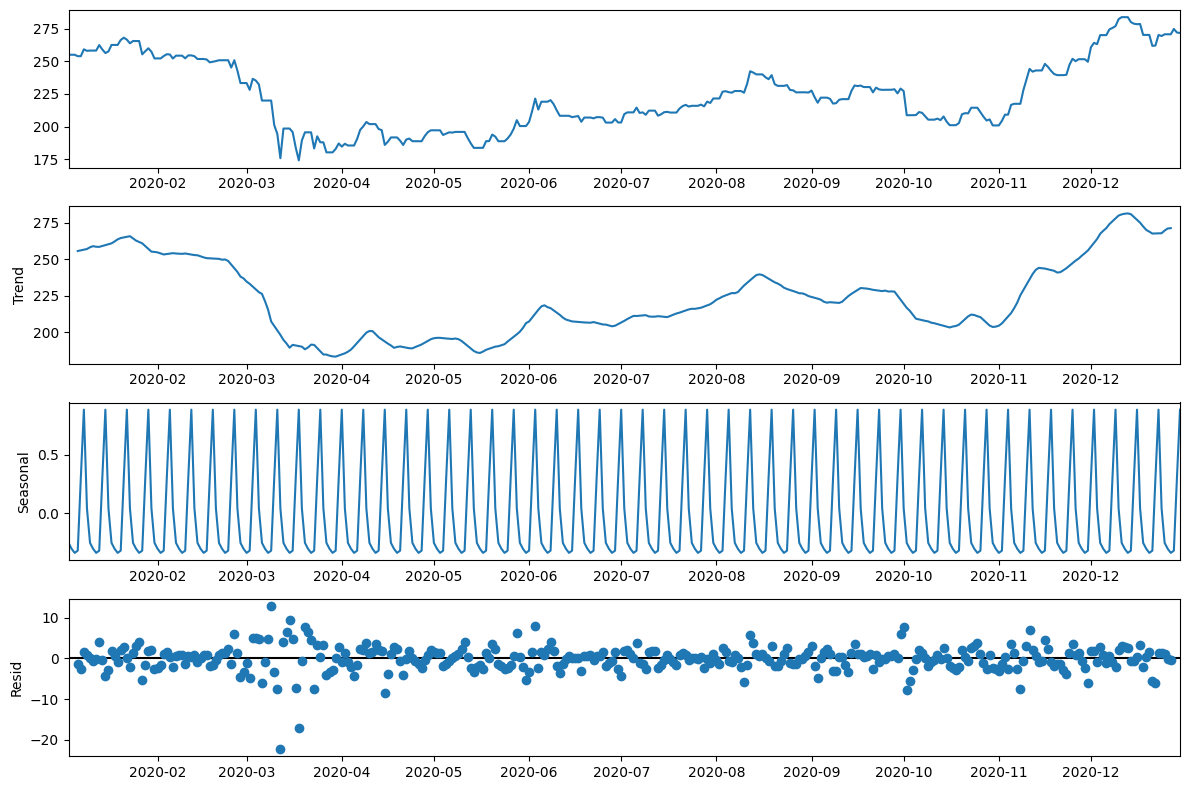

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

print("Plot seasonal componets of train_df_1:")
train_df_1 = add_seasonal_components(df=train_df_1, frequency='D', column='Close', add_to_df=True, plot=True)
test_df_1 = add_seasonal_components(df=test_df_1, frequency='D', column='Close', add_to_df=True, plot=False)

the original data (first plot) is very similar to the Trend data (second plot), indicating seasonality in the timeseries data is not significant.

- 3-4. PACF: the autocorrelation function

The PACF is an alternative to the ACF. Rather than giving the autocorrelations, it gives you the partial autocorrelation. This autocorrelation is called partial, because with each step back in the past, only additional autocorrelation is listed. This is different from the ACF, as the ACF contains duplicate correlations when variability can be explained by multiple points in time.

you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

The autocorrelation analysis helps in detecting hidden patterns and seasonality and in checking for randomness. It is especially important when you intend to use an ARIMA model for forecasting because the autocorrelation analysis helps to identify the AR and MA parameters for the ARIMA model.

In [ ]:
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(train_df_1['Close'])

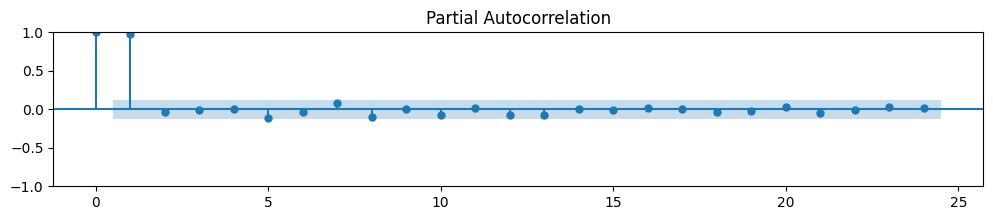

In [ ]:
rcParams['figure.figsize'] = 12, 2
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_df_1['Close'], method='ywm');

There's little autocorrelation after the first two dates, meaning only the next date would be highly correlated with each date in the timeseries data, which makes sense for stock market price data.

### <b>4. normalize scales</b>

* use the StandardScaler, rather than the MinMaxScaler,
The reason is that stock prices are ever-changing, and there are no true min or max values.
It doesn’t make sense to use the MinMaxScaler, although this choice probably won’t lead to
disastrous results at the end of the day;

In [ ]:
normalized_train_df_1, normalized_test_df_1 = normalize_scale(train_df_1, test_df_1, method="standard", exclude_column='Close')
normalized_train_df_1.describe()

,Close,Open,High,Low,Vol.,Change %,Weekly SMA,Monthly SMA,Quarterly SMA,Weekly EMA,Monthly EMA,Quarterly EMA,Month,Day,Weekday,Trend,Seasonal,Residual
count,250.000000,2.500000e+02,2.500000e+02,2.500000e+02,250.000000,2.500000e+02,2.440000e+02,2.210000e+02,1.600000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.500000e+02,2.460000e+02,2.500000e+02,2.460000e+02
mean,224.216280,-2.842171e-17,1.122658e-15,1.705303e-16,0.000000,-2.131628e-17,1.747236e-16,1.253899e-15,-1.554312e-16,4.973799e-16,-5.115908e-16,2.273737e-15,1.136868e-16,9.903189e-17,3.108624e-17,-5.487932e-16,-2.664535e-18,7.220963e-18
std,26.778554,1.002006e+00,1.002006e+00,1.002006e+00,1.002006,1.002006e+00,1.002056e+00,1.002270e+00,1.003140e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002006e+00,1.002039e+00,1.002006e+00,1.002039e+00
min,174.270000,-1.842935e+00,-1.686389e+00,-1.822672e+00,-1.522260,-4.147471e+00,-1.481173e+00,-1.466743e+00,-1.646413e+00,-1.484374e+00,-1.442682e+00,-1.158744e+00,-1.625037e+00,-1.729325e+00,-1.422742e+00,-1.551809e+00,-1.036980e+00,-6.814241e+00
25%,203.790000,-7.644503e-01,-7.795605e-01,-7.446363e-01,-0.687759,-4.580563e-01,-6.786079e-01,-7.548754e-01,-8.062869e-01,-6.950752e-01,-8.445118e-01,-8.044405e-01,-7.532358e-01,-8.094714e-01,-7.142049e-01,-7.319138e-01,-8.834194e-01,-4.569990e-01
50%,220.145000,-1.568639e-01,-1.728705e-01,-1.642128e-01,-0.208069,-5.499641e-03,-1.445320e-01,-6.522494e-02,8.375928e-02,-1.299714e-01,-1.258661e-01,-3.393298e-01,1.185649e-01,-4.599269e-03,-5.668293e-03,-1.561760e-01,-2.016100e-01,8.697638e-02
75%,247.825000,8.930813e-01,8.577104e-01,8.459921e-01,0.388021,5.418784e-01,7.749575e-01,4.754287e-01,5.325338e-01,8.357387e-01,8.336402e-01,6.211810e-01,9.903656e-01,8.002728e-01,7.028683e-01,7.779803e-01,3.921471e-01,5.177492e-01
max,283.730000,2.288127e+00,2.295581e+00,2.183162e+00,4.603962,5.537242e+00,2.198452e+00,2.341664e+00,2.141993e+00,2.093425e+00,1.824321e+00,2.056014e+00,1.571566e+00,1.720127e+00,1.411405e+00,2.225260e+00,1.740114e+00,2.432579e+00


### <b>5. perform EDA, assess feature importance (feature selection)</b>

check feature importance and only use relevant ones
- run_chi_tests (chi-square test of independce) (Happy Customers, Term Deposit Marketing)
- correlation
- plot_histograms (Term Deposit Marketing)
- get_top_features (EDA and feature selection) (milestone 2)

Distribution of target "Close" and dependent variables:


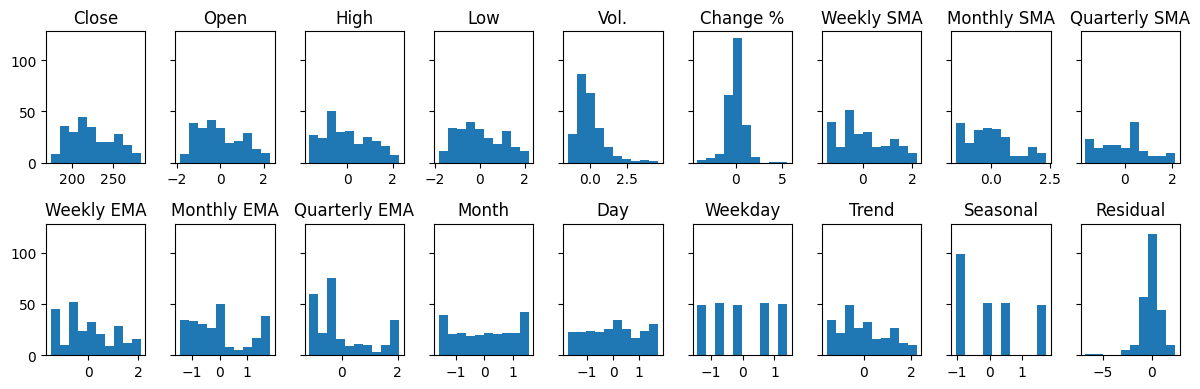

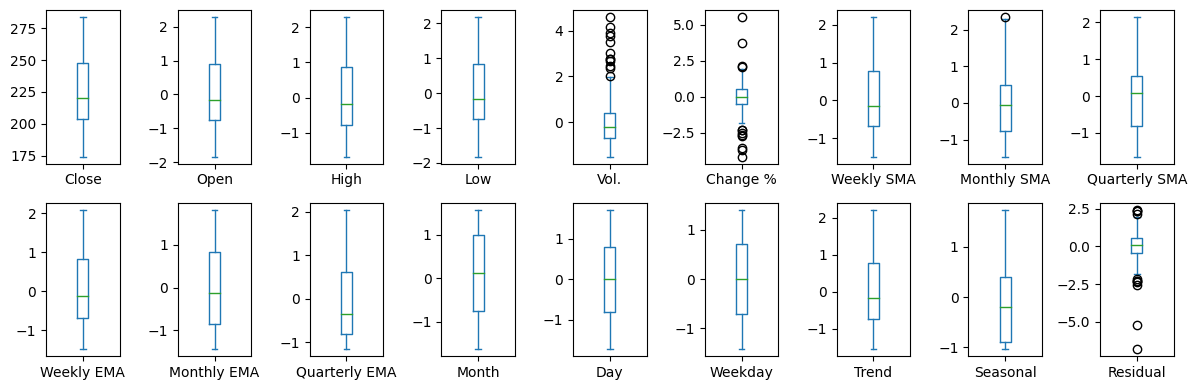

In [ ]:
plot_histograms(data=normalized_train_df_1,
                target="Close", target_figsize=(2,2),
                dependent_layout=(2,9), dependent_figsize=(12, 4),
                include_boxplots=True)

In [ ]:
results_dfs = run_chi_tests(normalized_train_df_1, target='Close', significance_level=0.05,
                            plot_title=None, plot_title_y=None,
                            plot_row=3, plot_col=6, figsize=None, plot=False,
                            rotate_x_label_col=[], rotate_angle=None,
                            h_pad=3, print_result_df=False,
                            independence_test=True,
                            goodness_of_fit_test=False)

print("""
If the null hypothesis is not rejected at the significance level of 0.05,
the Variable and the target (i.e. Close) are independent of each other.
""")
results_dfs[0]


If the null hypothesis is not rejected at the significance level of 0.05,
the Variable and the target (i.e. Close) are independent of each other.



,Independent Variable,Chi-square,P-value,Reject Null Hypothesis at alpha=0.05?
Variable,,,,
Weekly EMA,NaN,61250.000000,0.241223,No
Monthly EMA,NaN,61250.000000,0.241223,No
Quarterly EMA,NaN,61250.000000,0.241223,No
Vol.,NaN,60250.000000,0.257685,No
High,NaN,59750.000000,0.266231,No
Low,NaN,59750.000000,0.266231,No
Trend,NaN,59286.000000,0.241247,No
Residual,NaN,59286.000000,0.241247,No
Weekly SMA,NaN,58072.000000,0.245398,No


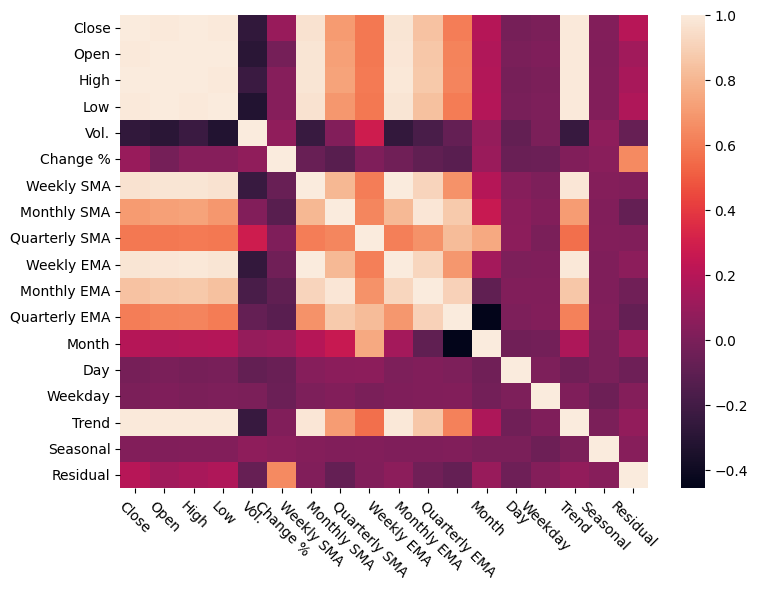

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(normalized_train_df_1.corr())
plt.xticks(rotation = -45)
plt.tight_layout()

In [ ]:
corr_df = normalized_train_df_1.corr()
print("Features with correlation equal to or lower than 0.7:")
print(corr_df[['Close']][corr_df.loc['Close'] <= 0.7])
print("\nFeatures with correlation higher than 0.7:")
print(corr_df[['Close']][corr_df.loc['Close'] > 0.7])

cols_to_keep = list(corr_df['Close'][corr_df.loc['Close'] > 0.7].index)
print("Features to use for training a prediction model:")
cols_to_keep

Features with correlation equal to or lower than 0.7:
                  Close
Vol.          -0.265379
Change %       0.099591
Quarterly SMA  0.589865
Quarterly EMA  0.603654
Month          0.194907
Day           -0.016961
Weekday        0.003600
Seasonal       0.025313
Residual       0.201241

Features with correlation higher than 0.7:
                Close
Close        1.000000
Open         0.989138
High         0.995150
Low          0.993580
Weekly SMA   0.965238
Monthly SMA  0.701028
Weekly EMA   0.976251
Monthly EMA  0.845845
Trend        0.992077
Features to use for training a prediction model:


['Close',
 'Open',
 'High',
 'Low',
 'Weekly SMA',
 'Monthly SMA',
 'Weekly EMA',
 'Monthly EMA',
 'Trend']

In [ ]:
# import matplotlib.pyplot as plt

# train_df_1['Quarterly EMA'].plot(label='Quarterly EMA')
# train_df_1['Quarterly SMA'].plot(label='Quarterly SMA')
# plt.legend();

In [ ]:
# from statsmodels.tsa.api import SimpleExpSmoothing

# es = SimpleExpSmoothing(train_df_1.Close.values)
# es.fit(smoothing_level=0.1)

# plt.plot(train_df_1.Close.values, label='Close')
# plt.plot(es.predict(es.params, start=0, end=None), label='Predicted')
# plt.legend();

### <b>5. Train a model</b>

* for nan values, you could consider discarding them if you have enough data.
Or you could plot the data to see how the nan values can be filled (e.g. average, ffill, bfill, etc.). It could be hard to figure this out, so it such cases, could just drop the nan values becausing imputing can bring bias that might not be helpful to the model/predictions.

In [ ]:
temp_train_df = normalized_train_df_1[cols_to_keep].asfreq('D').ffill().dropna(axis=1)
y_train_1 = temp_train_df.Close
X_train_1 = temp_train_df.drop('Close', axis=1)

temp_test_df = normalized_test_df_1[cols_to_keep].asfreq('D').ffill().dropna(axis=1)
y_test_1 = temp_test_df.Close
X_test_1 = temp_test_df.drop('Close', axis=1)

In [14]:
# https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train_1, 
                    exogenous= X_train_1,
                    start_p=1, max_p=7, 
                    start_q=1, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    suppress_warnings=True, 
                    stepwise=True)
step_wise.summary()

# https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1069.382, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1024.346, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1067.382, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1012.640, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=994.305, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=982.747, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=982.715, Time=0.15 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=981.963, Time=0.22 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=972.050, Time=0.24 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(7,1,0)(0,0,0)[0]             : AIC=970.052, Time=0.16 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=979.964, Time=0.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  334
Model:               SARIMAX(7, 1, 0)   Log Likelihood                -477.026
Date:                Fri, 16 Jun 2023   AIC                            970.052
Time:                        20:28:22   BIC                           1000.517
Sample:                    02-02-2020   HQIC                           982.200
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5750      0.065     -8.854      0.000      -0.702      -0.448
ar.L2         -0.4436      0.077     -5.781      0.000      -0.594      -0.293
ar.L3         -0.4601      0.070     -6.547      0.000      -0.598      -0.322
ar.L4         -0.3565      0.073     -4.897      0.000      -0.499      -0.214
ar.L5         -0.2086      0.078     -2.681      0.007      -0.361      -0.056
ar.L6         -0.1993      0.066     -3.024      0.002      -0.328      -0.070
ar.L7         -0.1899      0.051     -3.689      0.000      -0.291      -0.089
sigma2         1.0247      0.138      7.403      0.000       0.753       1.296
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                15.19
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.06
Prob(H) (two-sided):                  0.83   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                               SARIMAX Results                                
Dep. Variable:             Price Move   No. Observations:                  334
Model:               SARIMAX(7, 1, 0)   Log Likelihood                -478.994
Date:                Fri, 16 Jun 2023   AIC                           1009.988
Time:                        20:29:04   BIC                           1109.000
Sample:                    02-02-2020   HQIC                          1049.470
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Close (-1 day)         -0.1077      0.025     -4.267      0.000      -0.157      -0.058
Open (-1 day)           0.0133      0.028      0.478      0.633      -0.041       0.068
High (-1 day)   

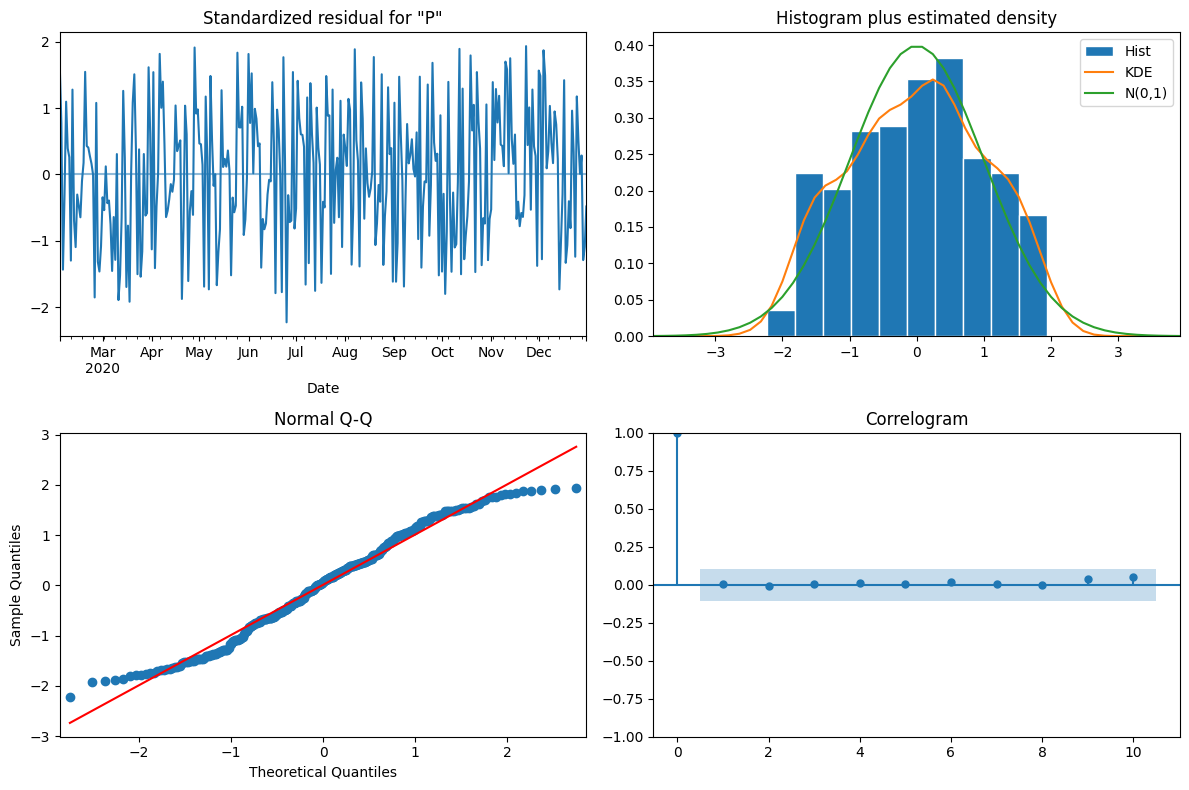

In [16]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

sarimax_model = SARIMAX(
    endog = y_train_1,
    exog = X_train_1,
    order=(7,1,0),
    # seasonal_order=(0,1,0,7)
    )
results = sarimax_model.fit(disp=False)
print(results.summary())

results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

The plot_diagnostics method above produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
1. Standardized residuals over time
2. Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
3. Normal Q-Q plot, with Normal reference line.
4. Correlogram

In [23]:
from datetime import timedelta

pred = results.get_prediction(start=X_train_1.shape[0],
                              end=X_train_1.shape[0] + X_test_1.shape[0] - 1,
                              exog=X_test_1)
pred_ci = pred.conf_int()
pred_mean = pred.predicted_mean

# Push the dates to 4 days later in the predictions since there's no trading data between Dec 31th and Jan 3nd.
# pred_mean.index += timedelta(days=4)
# pred_ci.index += timedelta(days=4)

# ax = y_test_1.plot(label='Observed', figsize=(12, 4))
# pred_mean.plot(ax=ax, label='Predicted', alpha=.7)

# # ax.fill_between(pred_ci.index,
# #                 pred_ci.iloc[:, 0], # lower band/confidence interval
# #                 pred_ci.iloc[:, 1], # upper band/confidence interval
# #                 color='r', alpha=.2)


# mean = y_test_1.mean()
# std = y_test_1.std()

# upper_band = y_test_1 + (std * 1.5)
# lower_band = y_test_1 - (std * 1.5)

# ax.fill_between(y_test_1.index,
#                 lower_band,
#                 upper_band,
#                 color='b', alpha=.2)


# ax.set_xlabel('Date')
# ax.set_ylabel('Close')
# plt.title("Observed and Predicted values on a daily basis")
# plt.legend()
# plt.tight_layout()
# plt.show()

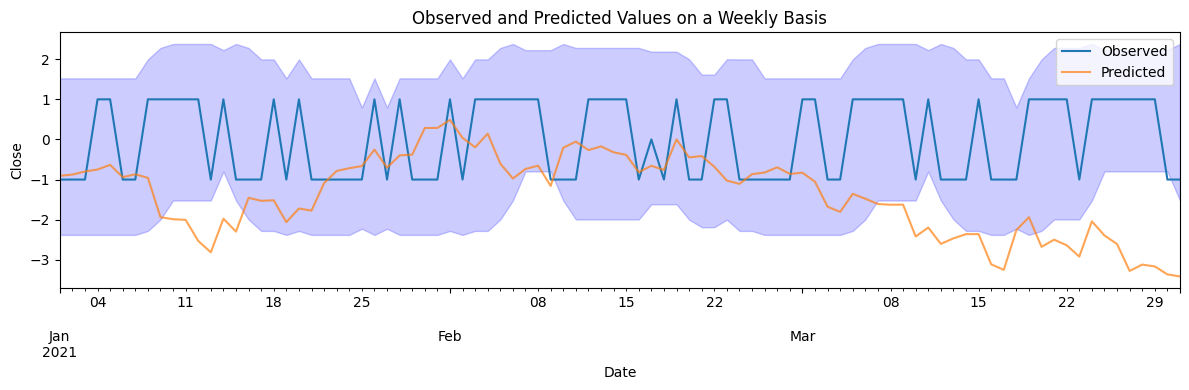

In [24]:
ax = y_test_1.plot(label='Observed', figsize=(12, 4))
pred_mean.plot(ax=ax, label='Predicted', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0], # lower band/confidence interval
#                 pred_ci.iloc[:, 1], # upper band/confidence interval
#                 color='r', alpha=.2)


time_period = 7
rolling_mean = y_test_1.rolling(window=time_period).mean()
rolling_std = y_test_1.rolling(window=time_period).std()

upper_band = (rolling_mean + (rolling_std * 2)).fillna(method='backfill').rename('Upper Band')
lower_band = (rolling_mean - (rolling_std * 2)).fillna(method='backfill').rename('Lower Band')

ax.fill_between(y_test_1.index,
                lower_band,
                upper_band,
                color='b', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.title("Observed and Predicted Values on a Weekly Basis")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
results_df

,Price Move,Upper Band,Lower Band,Predicted,Trade Decision,No. of Stock,Balance,Capital Return
2021-01-01,-1.0,1.523229,-2.380372,NaN,Hold,10,2000,0
2021-01-02,-1.0,1.523229,-2.380372,NaN,Hold,10,2000,0
2021-01-03,-1.0,1.523229,-2.380372,NaN,Hold,10,2000,0
2021-01-04,1.0,1.523229,-2.380372,NaN,Hold,10,2000,0
2021-01-05,1.0,1.523229,-2.380372,-0.907012,Sell,8,2002,2
...,...,...,...,...,...,...,...,...
2021-03-31,-1.0,2.380372,-1.523229,-3.277997,Buy,-2002,0,-2000
2021-04-01,NaN,NaN,NaN,-3.120225,Hold,-2002,0,-2000
2021-04-02,NaN,NaN,NaN,-3.165064,Hold,-2002,0,-2000
2021-04-03,NaN,NaN,NaN,-3.363983,Hold,-2002,0,-2000


In [21]:
import pandas as pd

results_df = pd.concat([y_test_1,
                        upper_band,
                        lower_band,
                        pred_mean.rename('Predicted')], axis=1)
results_df['Trade Decision'] = 'Hold'
results_df['No. of Stock'] = 0
results_df['Balance'] = 0

first_index = results_df.index[0]
last_index = results_df.index[-1]

max_no_stock_to_trade = 2
initial_balance = 2000
initial_no_stock = 10
results_df.loc[first_index, 'Balance'] = -initial_balance
results_df.loc[first_index, 'No. of Stock'] = initial_no_stock

for i, row in results_df.iterrows():
    target = row['Price Move']
    upper = row['Upper Band']
    lower = row['Lower Band']
    pred = row['Predicted']
    
    if i == first_index:
        previous_balance = initial_balance
        previous_no_stock = initial_no_stock
    else:
        previous_balance = results_df.loc[previous_index, 'Balance']
        previous_no_stock = results_df.loc[previous_index, 'No. of Stock']

    if (pred < lower) and (i != last_index) and (previous_balance >= target):
        results_df.loc[i, 'Trade Decision'] = 'Buy'
        max_no_stock_to_buy = previous_balance // target
        no_stock_to_buy = min( max_no_stock_to_trade, max_no_stock_to_buy )
        results_df.loc[i, 'Balance'] = previous_balance - (target * no_stock_to_buy)
        results_df.loc[i, 'No. of Stock'] = previous_no_stock + no_stock_to_buy
    elif ((pred > lower) or (i == last_index)) and (previous_no_stock > 0):
        results_df.loc[i, 'Trade Decision'] = 'Sell'        
        no_stock_to_sell = min( max_no_stock_to_trade, previous_no_stock)
        results_df.loc[i, 'Balance'] = previous_balance + (target * no_stock_to_sell)
        results_df.loc[i, 'No. of Stock'] = previous_no_stock - no_stock_to_sell

    if results_df.loc[i, 'Trade Decision'] == 'Hold':
        results_df.loc[i, 'Balance'] = previous_balance
        results_df.loc[i, 'No. of Stock'] = previous_no_stock

    previous_index = i

results_df['Capital Return'] = results_df['Balance'] - initial_balance
results_df.tail()


,Price Move,Upper Band,Lower Band,Predicted,Trade Decision,No. of Stock,Balance,Capital Return
2021-03-31,-1.0,2.380372,-1.523229,-3.277997,Buy,-2002,0,-2000
2021-04-01,NaN,NaN,NaN,-3.120225,Hold,-2002,0,-2000
2021-04-02,NaN,NaN,NaN,-3.165064,Hold,-2002,0,-2000
2021-04-03,NaN,NaN,NaN,-3.363983,Hold,-2002,0,-2000
2021-04-04,NaN,NaN,NaN,-3.416594,Hold,-2002,0,-2000


In [22]:
results_df.head(60)

,Price Move,Upper Band,Lower Band,Predicted,Trade Decision,No. of Stock,Balance,Capital Return
2021-01-01,-1.0,1.523229,-2.380372,NaN,Hold,10,2000,0
2021-01-02,-1.0,1.523229,-2.380372,NaN,Hold,10,2000,0
2021-01-03,-1.0,1.523229,-2.380372,NaN,Hold,10,2000,0
2021-01-04,1.0,1.523229,-2.380372,NaN,Hold,10,2000,0
2021-01-05,1.0,1.523229,-2.380372,-0.907012,Sell,8,2002,2
2021-01-06,-1.0,1.523229,-2.380372,-0.875832,Sell,6,2000,0
2021-01-07,-1.0,1.523229,-2.380372,-0.799032,Sell,4,1998,-2
2021-01-08,1.0,1.995233,-2.280947,-0.749283,Sell,2,2000,0
2021-01-09,1.0,2.280947,-1.995233,-0.633275,Sell,0,2002,2
2021-01-10,1.0,2.380372,-1.523229,-0.939167,Hold,0,2002,2


if the predicted price is lower than the lowerbound =>  buy
if the predicted price is within the Bollinger band => hold
if the predicted price is higher than the upperbound— => sell

1 train a model and predict on a daily, weekly and monthly basis.

2 calculate threshold/uncertainty (of the prediction) (+ bollinger band of the observed data?)<br>
Typical values used:<br>
Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)<br>
Medium term: 20 day moving average, bands at 2 standard deviations.<br>
Long term: 50 day moving average, bands at 2.5 standard deviations.<br>
                                                       
3 decide to buy/hold/sell based on the threshold

4 store the value/profit if I had traded based on the decision. (also need to define how many money/stock I already have.)

SARIMAX is a powerful tool for modeling and forecasting time series data, especially when there are known seasonal patterns and the influence of exogenous variables needs to be considered.

In a SARIMAX model, the time series is assumed to have both non-seasonal and seasonal components. The non-seasonal component is captured by the ARIMA model, while the seasonal component is captured by the seasonal ARIMA (SARIMA) model. The inclusion of exogenous variables allows for the incorporation of additional factors that may influence the time series.

The SARIMAX model is typically denoted as SARIMAX(p, d, q)(P, D, Q, s), where:

p, d, and q are the orders of the non-seasonal AR, differencing, and MA components, respectively.
P, D, Q, and s are the orders of the seasonal AR, differencing, MA components, and the seasonal period, respectively.
Exogenous variables can be included in the model by specifying them separately.

The SARIMAX model assumes that the time series is stationary after differencing. It models the relationship between the observations and the lags of the observations (autoregressive terms), the differences between observations (differencing terms), and the errors (moving average terms), both in the non-seasonal and seasonal components.

p is the number of autoregressive terms
d is the number of non-seasonal differences needed for stationarity
q is the number of lagged forecast errors in the prediction equation

ARIMA. it just takes the past values of the stock market.

=> move on to SARIMA. S stands for seasonality.

=> SARIMAX - also takes into account external features (i.e, other features)
SARIMAX stands for ‘Seasonal Auto Regressive Integrated Moving Average with eXogenus factors’

=> primarily they are used for understanding the patterns or features of the time series data but we can use them for predictions.

facebook's PROPHET. easy to understand. conceptually similar to SARIMAX.

Uber's timeseries prediction model.


https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b

In [27]:
train_df_1

,Close,Open,High,Low,Vol.,Change %,Close (-1 day),Open (-1 day),High (-1 day),Low (-1 day),...,Low (-1 week),Vol. (-1 week),Change % (-1 week),Close (-1 month),Open (-1 month),High (-1 month),Low (-1 month),Vol. (-1 month),Change % (-1 month),Price Move
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-02,252.20,258.50,259.20,252.17,47920000.0,-0.0199,252.20,258.50,259.20,252.17,...,264.21,27340000.0,0.0067,255.00,255.99,258.19,253.70,35850000.0,0.0010,-1
2020-02-03,253.99,251.80,254.96,251.10,52730000.0,0.0071,252.20,258.50,259.20,252.17,...,255.32,56450000.0,-0.0383,255.00,255.99,258.19,253.70,35850000.0,0.0010,1
2020-02-04,255.40,255.30,257.38,252.90,49790000.0,0.0056,253.99,251.80,254.96,251.10,...,254.10,48140000.0,0.0093,255.00,255.99,258.19,253.70,35850000.0,0.0010,1
2020-02-05,255.20,255.89,257.66,253.14,50760000.0,-0.0008,255.40,255.30,257.38,252.90,...,257.61,35050000.0,0.0087,253.90,254.75,254.84,251.40,22350000.0,-0.0043,-1
2020-02-06,252.11,256.50,258.00,251.86,43620000.0,-0.0121,255.20,255.89,257.66,253.14,...,255.27,31770000.0,-0.0101,253.90,254.75,254.84,251.40,22350000.0,-0.0043,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,270.64,269.97,271.00,268.28,11990000.0,0.0049,270.64,269.97,271.00,268.28,...,268.52,99270000.0,-0.0299,251.59,250.30,252.26,248.03,51430000.0,0.0060,1
2020-12-28,274.70,270.90,275.19,269.73,39040000.0,0.0150,270.64,269.97,271.00,268.28,...,259.70,120520000.0,-0.0310,251.59,250.30,252.26,248.03,51430000.0,0.0060,1
2020-12-29,272.00,275.91,276.43,271.26,39020000.0,-0.0098,274.70,270.90,275.19,269.73,...,257.05,105490000.0,0.0010,251.59,250.30,252.26,248.03,51430000.0,0.0060,-1


20:36:03 - cmdstanpy - INFO - Chain [1] start processing
20:36:03 - cmdstanpy - INFO - Chain [1] done processing
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


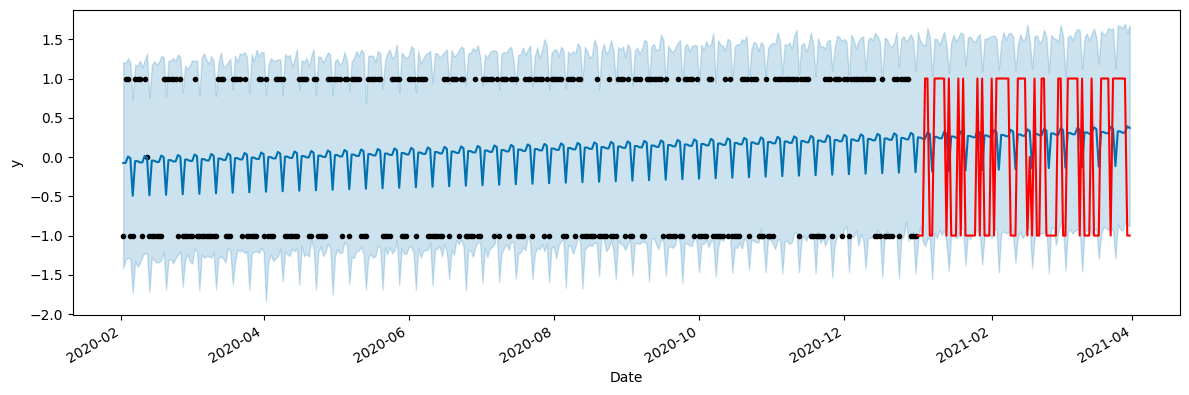

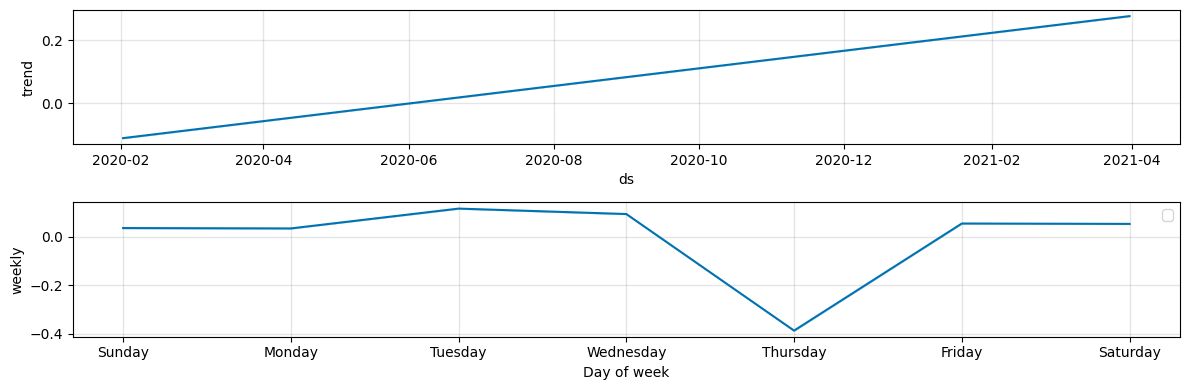

In [29]:
from prophet import Prophet
m = Prophet()
m.fit(train_df_1.reset_index().rename(columns={'Date': 'ds', 'Price Move': 'y'}))

# Forecast for the next 3 months
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
# print(forecast.tail())

m.plot(forecast, figsize=(12, 4))
y_test_1.plot(label='Close', color='red')
m.plot_components(forecast, figsize=(12, 4))
plt.legend();

3. set evaluation metrics
(e.g., Since stock prices prediction is essentially a regression problem,
 the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %)
 will be our current model evaluation metrics. Both are useful measures of forecast accuracy. )


4. build a prediction model
* When predicting short-term stock prices, it is generally better to focus on more recent data rather than using the data from the entire year. However, it's important to strike a balance between using recent data and having enough historical context. It's recommended to experiment with different time periods and evaluate the performance of your predictions to find the optimal balance.

* LSTM, short for Long Short-term Memory, is an extremely powerful algorithm for time series.
    It can capture historical trend patterns, and predict future values with high accuracy. 
https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233
https://www.projectpro.io/article/stock-price-prediction-using-machine-learning-project/571
=> can be difficult/time-consuming to understand. can be tried out after trying simpler models.

* Seasonal autoregressive integrated moving-average with exogenous regressors (SARIMAX)
The most complex variant is the SARIMAX model. It regroups AR, MA, differencing, and seasonal effects.
On top of that, it adds the X: external variables. If you have any variables that could help your model to improve,
you could add them with SARIMAX.

* exponential smoothing
from statsmodels.tsa.api import SimpleExpSmoothing
es = SimpleExpSmoothing(co2_data.co2.values)
es.fit(smoothing_level=0.01)
plt.plot(co2_data.co2.values)
plt.plot(es.predict(es.params, start=0, end=None))
plt.show()
=> takes in only 1 column

* Reinforcement learning
https://www.analyticsvidhya.com/blog/2020/10/reinforcement-learning-stock-price-prediction/


5. evaluate model performance
=> create bollinger bands using the prediced price and recommend buy, hold, or sell decisions?


6. based on the final model prediction, recommend BUY, HOLD, SELL decisions for each stock.
(Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.)


7. evaluate on the basis of capital returns (based on the trading decisions).
how to quantify or calculate the returns when we don't know how many stocks we had and when we bought them?


8. use bollinger bands to measure the system/model's effectiveness??

Candlestick charts are used by traders to determine possible price movement based on past patterns. Candlesticks are useful when trading as they show four price points (open, close, high, and low) throughout the period of time the trader specifies.

In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(data=[
#     go.Candlestick(
#     x=train_df_1.index,
#     open=train_df_1['Open'],
#     high=train_df_1['High'],
#     low=train_df_1['Low'],
#     close=train_df_1['Close']
#     )
#     ])

# # fig.update_layout(
# #     margin=dict(l=30, r=30, t=10, b=10),
# #     # paper_bgcolor="LightSteelBlue",
# # )

# fig.update_layout(
#     title=f"{stock_name_1}: Daily OHLC", 
#     yaxis_title="Price (USD)",
#     width=900,
#     height=600)

# fig.show()

In [ ]:
# # Candlestick Chart and Volume Separately
# # Source: https://medium.com/codex/creating-candlestick-charts-using-python-plotly-8081c4820351

# from plotly.subplots import make_subplots

# # figure with secondary y-axis
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # candlestick
# fig.add_trace(
#     go.Candlestick(
#         x=train_df_1.index,
#         open=train_df_1.Open,
#         high=train_df_1.High,
#         low=train_df_1.Low,
#         close=train_df_1.Close,
#         showlegend=False),
#     row=1,
#     col=1,
#     secondary_y=True
# )

# # volume
# fig.add_trace(
#     go.Bar(x=train_df_1.index,
#            y=train_df_1["Vol."],
#            showlegend=False,
#            marker={
#                "color": "grey",
#            }),
#     secondary_y=False,
# )

# fig.update_layout(title=f"{stock_name_1}: Daily OHLCV",
#                   yaxis_title="Price (USD)",
#                   width=900,
#                   height=600)

# fig.show()

if the target is short-term decision, 

bullish patterns -> price likely to rise => buy
bearish patterns -> price likely to fall => sell

If a candlestick pattern doesn’t indicate a change in market direction, it is what is known as a continuation pattern. These can help traders to identify a period of rest in the market, when there is market indecision or neutral price movement. => hold

https://neptune.ai/blog/predicting-stock-prices-using-machine-learning

https://www.simplilearn.com/tutorials/machine-learning-tutorial/stock-price-prediction-using-machine-learning

2. Create Bollinger Bands for 2020 for each company

Typical values used:

Short term: 10 day moving average, bands at 1.5 standard deviations. (1.5 times the standard dev. +/- the SMA)

Medium term: 20 day moving average, bands at 2 standard deviations.

Long term: 50 day moving average, bands at 2.5 standard deviations.

From Semih:

Typically bollinger bands are used to make buy and sell decisions if the predicted price is lower than the lowerbound—> buy if the predicted price is higher than the upperbound—> sell

My interpretation is (the way I would approach) we can use bollinger bands to label the data. Afterwards a classifier or a recommendation system could be developed to predict buy and sell decisions. Based on the recommended actions a loss or profit could be calculated. I don’t think there is only one approach but this is how I would approach it.

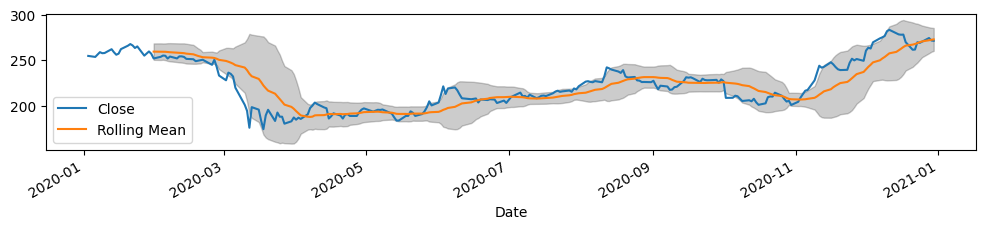

In [ ]:
import matplotlib.pyplot as plt

# Define time period and calculate rolling mean and standard deviation
time_period = 20
rolling_mean = train_df_1['Close'].rolling(window=time_period).mean()
rolling_std = train_df_1['Close'].rolling(window=time_period).std()

# Calculate upper and lower Bollinger Bands
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)

# Plot the data and the Bollinger Bands
ax = train_df_1['Close'].plot(label='Close')
plt.plot(rolling_mean, label='Rolling Mean')
ax.fill_between(
    rolling_mean.index,
    upper_band,
    lower_band,
    color='k', alpha=.2
)
# plt.plot(upper_band, label='Upper Bollinger Band')
# plt.plot(lower_band, label='Lower Bollinger Band')
plt.legend()
plt.show()